# Dynamic ecoregions

## Define inputs

In [1]:
# Inputs

input_file = "data/data-continental-united-states.csv"
# input_file = "data/data-nh-vt.csv"

geocode_precision = 4
# geocode_precision = 5

log_file = "run.log"

output_file = "output.geojson"

num_clusters = 120
# num_clusters = 3

## Set up logging

In [2]:
import logging

logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)

## Data flow

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


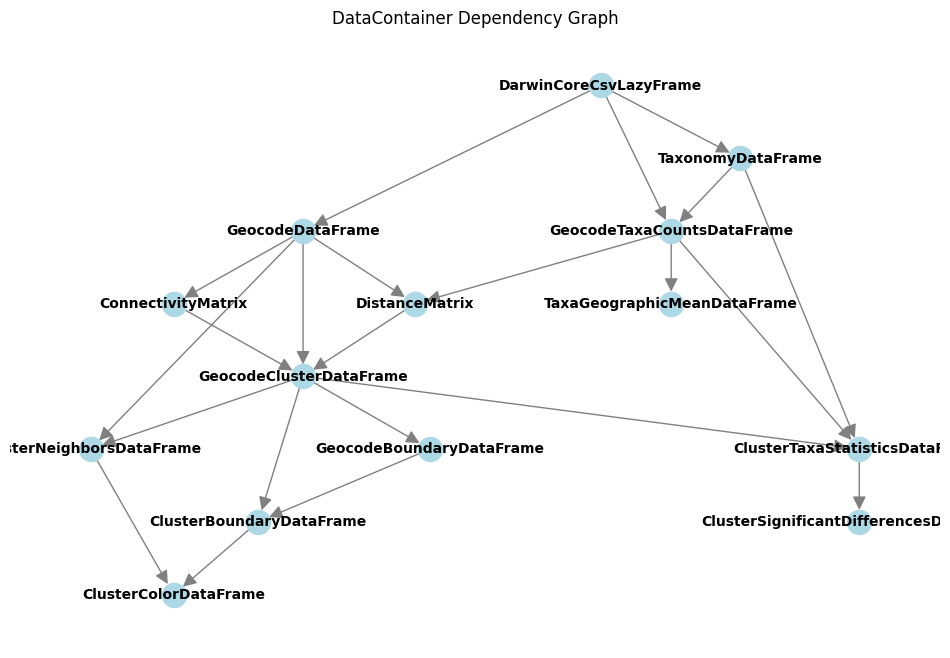

In [3]:
from src.dependency_graph import plot_dependency_graph

plot_dependency_graph()

## `DarwinCoreCsvLazyFrame`

### Build

In [4]:
from src.lazyframes.darwin_core_csv import DarwinCoreCsvLazyFrame

darwin_core_csv_lazy_frame = DarwinCoreCsvLazyFrame.build(input_file)

### Preview

In [5]:
darwin_core_csv_lazy_frame.lf.limit(3).collect()

gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
str,str,str,enum,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,u64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""4424226317""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Libellulidae""","""Sympetrum""",null,null,"""GENUS""","""Sympetrum Newman, 1833""","""Sympetrum""",null,"""US""",null,"""New York""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",42.96266,-76.740947,"""2191.0""",null,null,null,null,null,"""2019-09-06T10:30""","""6""","""9""","""2019""",1428195,null,"""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32505913""",null,"""Amy Guala""","""2019-09-11T01:33:07""","""CC_BY_NC_4_0""","""Amy Guala""","""Amy Guala""",null,null,"""2024-12-03T00:52:33.467Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423028148""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Lepidoptera""","""Geometridae""","""Nematocampa""","""Nematocampa resistaria""",null,"""SPECIES""","""Nematocampa resistaria (Herric…","""Nematocampa resistaria""",null,"""US""",null,"""Vermont""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",43.822608,-72.641412,"""5.0""",null,null,null,null,null,"""2019-09-11T22:08:52""","""11""","""9""","""2019""",1991012,"""1991012""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32566956""",null,"""bugguytad""","""2019-09-12T02:25:38""","""CC_BY_NC_4_0""","""bugguytad""","""bugguytad""",null,null,"""2024-12-03T01:38:46.617Z""","""StillImage;StillImage;StillIma…","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423041120""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Coenagrionidae""","""Argia""","""Argia moesta""",null,"""SPECIES""","""Argia moesta (Hagen, 1861)""","""Argia moesta""",null,"""US""",null,"""Texas""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",30.99463,-103.662658,null,null,null,null,null,null,"""2019-09-08T09:01""","""8""","""9""","""2019""",5051399,"""5051399""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32612673""",null,"""Todd Fitzgerald""","""2019-09-12T22:11:30""","""CC_BY_NC_4_0""","""Todd Fitzgerald""","""Todd Fitzgerald""",null,null,"""2024-12-03T01:38:10.816Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"


## `GeohashDataFrame`

### Build

In [6]:
from src.dataframes.geocode import GeocodeDataFrame

geocode_dataframe = GeocodeDataFrame.build(
    darwin_core_csv_lazy_frame,
    geocode_precision,
)

### Preview

In [7]:
geocode_dataframe.df

geocode,center,direct_neighbors,direct_and_indirect_neighbors
str,struct[2],list[str],list[str]
"""840e491ffffffff""","{49.369298,-67.913007}","[""840e497ffffffff"", ""840e493ffffffff"", ""840e49bffffffff""]","[""840e497ffffffff"", ""840e493ffffffff"", ""840e49bffffffff""]"
"""840e493ffffffff""","{48.946311,-67.83016}","[""840e49bffffffff"", ""840e491ffffffff"", … ""842b14dffffffff""]","[""840e49bffffffff"", ""840e491ffffffff"", … ""842b14dffffffff""]"
"""840e497ffffffff""","{49.104076,-68.442117}","[""840e491ffffffff"", ""840e4bbffffffff"", … ""840e493ffffffff""]","[""840e491ffffffff"", ""840e4bbffffffff"", … ""840e493ffffffff""]"
"""840e49bffffffff""","{49.208357,-67.299825}","[""842b325ffffffff"", ""840e491ffffffff"", … ""842b327ffffffff""]","[""842b325ffffffff"", ""840e491ffffffff"", … ""842b327ffffffff""]"
"""840e4b1ffffffff""","{49.410776,-69.681628}","[""840e4b7ffffffff"", ""840e4b3ffffffff"", ""840e4bbffffffff""]","[""840e4b7ffffffff"", ""840e4b3ffffffff"", ""840e4bbffffffff""]"
…,…,…,…
"""844db61ffffffff""","{31.586253,-71.677466}",[],"[""844db4dffffffff""]"
"""8450903ffffffff""","{25.536202,-120.791687}",[],"[""84486d7ffffffff""]"
"""8450997ffffffff""","{28.357494,-123.742585}",[],"[""8429265ffffffff"", ""8450aa7ffffffff""]"


## `TaxonomyDataFrame`

### Build

In [8]:
from src.dataframes.taxonomy import TaxonomyDataFrame

taxonomy_dataframe = TaxonomyDataFrame.build(darwin_core_csv_lazy_frame)

### Preview

In [9]:
taxonomy_dataframe.df

taxonId,kingdom,phylum,class,order,family,genus,species,taxonRank,scientificName
u32,enum,str,str,str,str,str,str,str,str
0,"""Fungi""","""Basidiomycota""","""Agaricomycetes""","""Agaricales""","""Cortinariaceae""","""Cortinarius""","""Cortinarius miwok""","""SPECIES""","""Cortinarius miwok Bojantchev"""
1,"""Animalia""","""Mollusca""","""Bivalvia""","""Unionida""","""Unionidae""","""Pyganodon""","""Pyganodon lacustris""","""SPECIES""","""Pyganodon lacustris (I.Lea, 18…"
2,"""Animalia""","""Arthropoda""","""Copepoda""","""Calanoida""","""Calanidae""","""Calanus""","""Calanus hyperboreus""","""SPECIES""","""Calanus hyperboreus Krøyer, 18…"
3,"""Plantae""","""Tracheophyta""","""Magnoliopsida""","""Asterales""","""Campanulaceae""","""Campanula""","""Campanula parryi""","""SPECIES""","""Campanula parryi A.Gray"""
4,"""Animalia""","""Chordata""","""Mammalia""","""Chiroptera""","""Vespertilionidae""","""Dasypterus""","""Dasypterus xanthinus""","""SPECIES""","""Lasiurus xanthinus (Thomas, 18…"
…,…,…,…,…,…,…,…,…,…
101057,"""Animalia""","""Chordata""","""Amphibia""","""Anura""","""Scaphiopodidae""","""Spea""","""Spea multiplicata""","""SPECIES""","""Spea multiplicata (Cope, 1863)"""
101058,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Crabronidae""","""Philanthus""","""Philanthus bilunatus""","""SPECIES""","""Philanthus bilunatus Cresson, …"
101059,"""Animalia""","""Arthropoda""","""Arachnida""","""Araneae""","""Selenopidae""","""Selenops""","""Selenops mexicanus""","""SPECIES""","""Selenops mexicanus Keyserling,…"


## `GeohashSpeciesCountsDataFrame`

### Build

In [10]:
from src.dataframes.geocode_taxa_counts import GeocodeTaxaCountsDataFrame

geocode_taxa_counts_dataframe = GeocodeTaxaCountsDataFrame.build(
    darwin_core_csv_lazy_frame,
    geocode_precision,
    taxonomy_dataframe,
)

### Preview

In [11]:
geocode_taxa_counts_dataframe.df

geocode,taxonId,count
str,u32,u32
"""840e491ffffffff""",12755,1
"""840e491ffffffff""",40901,1
"""840e491ffffffff""",95973,10
"""840e491ffffffff""",79215,1
"""840e491ffffffff""",6293,1
…,…,…
"""844db61ffffffff""",88240,1
"""8450903ffffffff""",57124,1
"""8450997ffffffff""",78833,1


## `ConnectivityMatrix`

### Build

In [12]:
from src.matrices.connectivity import ConnectivityMatrix

connectivity_matrix = ConnectivityMatrix.build(geocode_dataframe)

### Shape

In [13]:
connectivity_matrix._connectivity_matrix.shape

(7416, 7416)

### Preview

In [14]:
connectivity_matrix._connectivity_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

## `DistanceMatrix`

In [15]:
from src.matrices.distance import DistanceMatrix

print(DistanceMatrix.__doc__)


    A distance matrix where each column and row is a geocode, and the cell at the intersection of a
    column and row is the similarity (or distance) between the two geocodes. Internally it is stored
    as a condensed distance matrix, which is a one-dimensional array containing the upper triangular
    part of the distance matrix.
    


### Build

In [16]:
distance_matrix = DistanceMatrix.build(
    geocode_taxa_counts_dataframe,
    geocode_dataframe,
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Shape

In [17]:
distance_matrix.squareform().shape

(7416, 7416)

### Preview

In [18]:
distance_matrix.squareform()

array([[0.00000000e+00, 9.94032098e-05, 1.73715590e-04, ...,
        2.00069582e-03, 1.52139854e-03, 1.44045006e-03],
       [9.94032098e-05, 0.00000000e+00, 2.68906047e-04, ...,
        1.92559342e-03, 1.44876782e-03, 1.37035554e-03],
       [1.73715590e-04, 2.68906047e-04, 0.00000000e+00, ...,
        2.08733311e-03, 1.60599049e-03, 1.52071102e-03],
       ...,
       [2.00069582e-03, 1.92559342e-03, 2.08733311e-03, ...,
        0.00000000e+00, 9.93038870e-04, 9.77337663e-04],
       [1.52139854e-03, 1.44876782e-03, 1.60599049e-03, ...,
        9.93038870e-04, 0.00000000e+00, 1.36637323e-04],
       [1.44045006e-03, 1.37035554e-03, 1.52071102e-03, ...,
        9.77337663e-04, 1.36637323e-04, 0.00000000e+00]])

## `GeohashClusterDataFrame`

### Build

In [19]:
from src.dataframes.geocode_cluster import GeocodeClusterDataFrame

geocode_cluster_dataframe = GeocodeClusterDataFrame.build(
    geocode_dataframe,
    distance_matrix,
    connectivity_matrix,
    num_clusters,
)

### Preview

In [20]:
geocode_cluster_dataframe.df.limit(3)

geocode,cluster
str,u32
"""840e491ffffffff""",7
"""840e493ffffffff""",7
"""840e497ffffffff""",7


In [21]:
# # TMP

# from src.dataframes.geocode_cluster import GeocodeClusterDataFrame
# from sklearn.metrics import silhouette_score

# results = []

# for i in range(2, 200):
#     geocode_cluster_dataframe = GeocodeClusterDataFrame.build(
#         geocode_dataframe,
#         distance_matrix,
#         connectivity_matrix,
#         num_clusters=i,
#     )
#     score = silhouette_score(
#         X=distance_matrix.squareform(),
#         labels=geocode_cluster_dataframe.df["cluster"],
#         metric="precomputed",
#     )
#     print(f"{i}: {score}")
#     results.append((i, score))

# results


## `ClusterNeighborsDataframe`

### Build

In [22]:
from src.dataframes.cluster_neighbors import ClusterNeighborsDataFrame

cluster_neighbors_dataframe = ClusterNeighborsDataFrame.build(
    geocode_dataframe,
    geocode_cluster_dataframe,
)

### Preview

In [23]:
cluster_neighbors_dataframe.df

cluster,direct_neighbors,direct_and_indirect_neighbors
u32,list[u32],list[u32]
0,[],"[29, 13]"
1,"[100, 102, … 24]","[100, 102, … 24]"
2,"[33, 99, … 59]","[33, 99, … 59]"
3,"[104, 41, … 57]","[104, 41, … 57]"
4,"[96, 101, … 30]","[96, 101, … 30]"
…,…,…
115,[15],[15]
116,"[25, 90, … 53]","[25, 90, … 53]"
117,"[34, 99]","[34, 99]"


## `ClusterTaxaStatisticsDataFrame`

### Build

In [24]:
from src.dataframes.cluster_taxa_statistics import ClusterTaxaStatisticsDataFrame

cluster_taxa_statistics_dataframe = ClusterTaxaStatisticsDataFrame.build(
    geocode_taxa_counts_dataframe,
    geocode_cluster_dataframe,
    taxonomy_dataframe,
)

### Preview

In [25]:
cluster_taxa_statistics_dataframe.df

cluster,taxonId,count,average
u32,u32,u32,f64
null,90870,13,2.5281e-7
null,31592,16,3.1115e-7
null,87065,320,0.000006
null,50998,73,0.000001
null,14449,26,5.0562e-7
…,…,…,…
112,7279,1,2.5478e-7
67,91385,2,2.5670e-7
5,16297,35,0.000101


## `ClusterSignificantDifferencesDataFrame`

### Build

In [26]:
from src.dataframes.cluster_significant_differences import ClusterSignificantDifferencesDataFrame

cluster_significant_differences_dataframe = ClusterSignificantDifferencesDataFrame.build(
    cluster_taxa_statistics_dataframe,
)

### Preview

In [27]:
cluster_significant_differences_dataframe.df.limit(3)

cluster,taxonId,percentage_difference
u32,u32,f64
0,100128,9.1011e6
0,55481,927252.407574
0,49444,1.6588e7


## `GeocodeBoundaryDataFrame`

### Build

In [28]:
from src.dataframes.geocode_boundary import GeocodeBoundaryDataFrame

geocode_boundary_dataframe = GeocodeBoundaryDataFrame.build(
    geocode_cluster_dataframe,
)

### Preview

In [29]:
geocode_boundary_dataframe.df

geocode,boundary
str,binary
"""840e491ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x116L$\xd0\xf0P\xc0E(\xdb\x0f\x9f\xccH@\xcbY\xae\xf4m\x09Q\xc0\x7f\xb1\x1db$\xc8H@\xac\x17\xa5\xb4\xe9\x12Q\xc0\xbe\\xddY\xb9\xaaH""…"
"""840e493ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x0a\xcc\xdc\x8b\x94\xebP\xc0\xf1\xb7\xad\xfea\x96H@g\x13M)\xf3\x03Q\xc0\xa1\xec\xeb\xef\xee\x91H@Z\xd7t\xe1]\x0dQ\xc0Ymw\xd5\x9ctH""…"
"""840e497ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xac\x17\xa5\xb4\xe9\x12Q\xc0\xbe\\xddY\xb9\xaaH@H\xab\xf9*^+Q\xc0\x12\xa9\xf8\xbb\x03\xa6H@\xc6\xe6\x87q\x9d4Q\xc0\xe7\x80zj\x8c\x88H""…"
"""840e49bffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xd3y|Og\xc9P\xc0r[\xca\xdf\xde\xb7H@s\x85\xe4\xb9\xed\xe1P\xc0\x86\xfcJ\x04\xa7\xb3H@\x0a\xcc\xdc\x8b\x94\xebP\xc0\xf1\xb7\xad\xfea\x96H""…"
"""840e4b1ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xef\x12L\xbf\x97bQ\xc0\xdd\x11k\x94D\xd2H@\xc3c\xe6\xe23{Q\xc0\xc6\xf8a$\x07\xcdH@\x9a^\xf5&\x18\x84Q\xc0\xbc\x8d)\x96G\xafH""…"
…,…
"""844db61ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xb9E\xd1\xc2\xaf\xe5Q\xc0\xad\xb2^\xa2-\xc6?@\xc5\xf1\xafR_\xf6Q\xc0V0!\xe5\xa3\xbb?@l\xe5\xef5\xfa\xfbQ\xc0\x15\x0d\xe5:\x86\x8b?""…"
"""8450903ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\x0c\xc7\xa6\xbf\xc3.^\xc04\x95\xea\xa02J9@K\xc9\xe7i\xdf!^\xc0\x10\xbbw\xc0;v9@\x0f\xfb\x0e\xae\xc2%^\xc0\x8f\x9b\x81ZZ\xb59""…"
"""8450997ffffffff""","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xfcV\x0cm:\xeb^\xc0\xa8[\x8bi\xc7\x1d<@\x10""\x85-\x92\xde^\xc0\x047\xf0c\xcaJ<@H\xc0\x8f\xed\xda\xe2^\xc0^+7\xed\x91\x88<""…"


## `ClusterBoundaryDataFrame`

### Build

In [30]:
from src.dataframes.cluster_boundary import ClusterBoundaryDataFrame

cluster_boundary_dataframe = ClusterBoundaryDataFrame.build(
    geocode_cluster_dataframe,
    geocode_boundary_dataframe,
)

### Preview

In [31]:
cluster_boundary_dataframe.df

cluster,boundary
u32,binary
0,"b""\x01\x06\x00\x00\x00\x03\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xe6\xb8`\xd5GkP\xc055""{\xc4\x89=@2\xaa\x1d\xe8>{P\xc0\x94\xf6Lpx\x82=@\x0eB\xd9\xc6\x93\x84""…"
1,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\xf3\x00\x00\x00\xd0\xd2\xcc&D\xa6U\xc0\xc8i$\x1c\x84\x06H@+\xeb;\x9e\x8e\xb9U\xc0>0\xf2\xb5\x8e\x19H@\x07\xdf\xfe\x96\xed\xb6U\xc0\x80S\xf9\x0c\xab8H""…"
2,"b""\x01\x03\x00\x00\x00\x02\x00\x00\x00v\x01\x00\x00\x0d\x92\x1b&\x01\xefY\xc0\xf9\xe6\xa4\x86\x1du@@\x9a.\x14\x8b\xef\xf0Y\xc0\xfe\x88X\xe61\x95@@\xe2\xee\xb4:\xa3\x02Z\xc0s\xe5\xd8y\xb3\xa2@""…"
3,"b""\x01\x03\x00\x00\x00\x02\x00\x00\x00\xfd\x00\x00\x00{\xdcZ\xbb\xdb\xe1Z\xc0\xfa\x1b\xfaX%U<@S\x8a\x96\xaf<\xe4Z\xc0\xae\xb0\x97\xfaO\x96<@\xb7\x00a\x20O\xd5Z\xc0\x98{\xdb\xd2\x03\xbe<""…"
4,"b""\x01\x06\x00\x00\x00\x1d\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0b\x00\x00\x00\x12\x87\xe2\xbf\xea\x0c`\xc0/\xe0i\xb6sZB@T\xaa\xfd\xd9\x98\x06`\xc0<\x08Pu\x87qB@#A\xf3\xb0j\xfb""…"
…,…
115,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xbcd-T\xbf\x16]\xc0(\xc4\x96\x06I\xd7H@\xdd\xf8\xf1\x8c\xb0$]\xc0\x142\x9a\x81\xb9\xc2H@\xc5Cp6\xee\x1c]\xc0\x0e:a\x16\xea\xa6H""…"
116,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00W\x00\x00\x00\xf8#\x0e\x06?\x1eU\xc0XV\x01\x0b\x19|C@Y\x00z\xc9\xb1-U\xc0\xb3\xa7\xb1\x1bL\x8eC@\x99)\x20\xe5\xf2?U\xc0\xd5&\xc4AU\x84C""…"
117,"b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xb7\x8a\x8e\xa3\xc2\X\xc0;+\x9bA\xcc\xc1G@+\xa3\xb6\xc5\xf0oX\xc0a\x10\xfc9?\xb2G@\xf1\x04\xc0y\x9cnX\xc0v\xb3\x14\xbe\xd0\x93G""…"


## `ClusterColorDataFrame`

### Build

In [32]:
from src.dataframes.cluster_color import ClusterColorDataFrame

cluster_colors_dataframe = ClusterColorDataFrame.build(
    cluster_neighbors_dataframe,
    cluster_boundary_dataframe,
)

### Preview

In [33]:
cluster_colors_dataframe.df

cluster,color
u32,str
7,"""#ffe793"""
11,"""#ffe793"""
12,"""#d0e1f2"""
99,"""#ffe793"""
9,"""#febf5a"""
…,…
110,"""#ffe793"""
113,"""#d0e1f2"""
114,"""#ffe793"""


## `GeocodeSilhouetteScoreDataFrame`

### Build

In [34]:
from src.dataframes.geocode_silhouette_score import GeocodeSilhouetteScoreDataFrame

geocode_silhouette_score_dataframe = GeocodeSilhouetteScoreDataFrame.build(
    cluster_neighbors_dataframe,
    distance_matrix,
    geocode_cluster_dataframe,
)

### Preview

In [35]:
geocode_silhouette_score_dataframe.df.sort(by="silhouette_score")

geocode,silhouette_score
str,f64
"""8448761ffffffff""",-0.940835
"""8444331ffffffff""",-0.936243
"""842a239ffffffff""",-0.934593
"""8448631ffffffff""",-0.931223
"""844c83dffffffff""",-0.930588
…,…
"""84489abffffffff""",0.644113
"""84489c5ffffffff""",0.644768
"""84489a9ffffffff""",0.648685


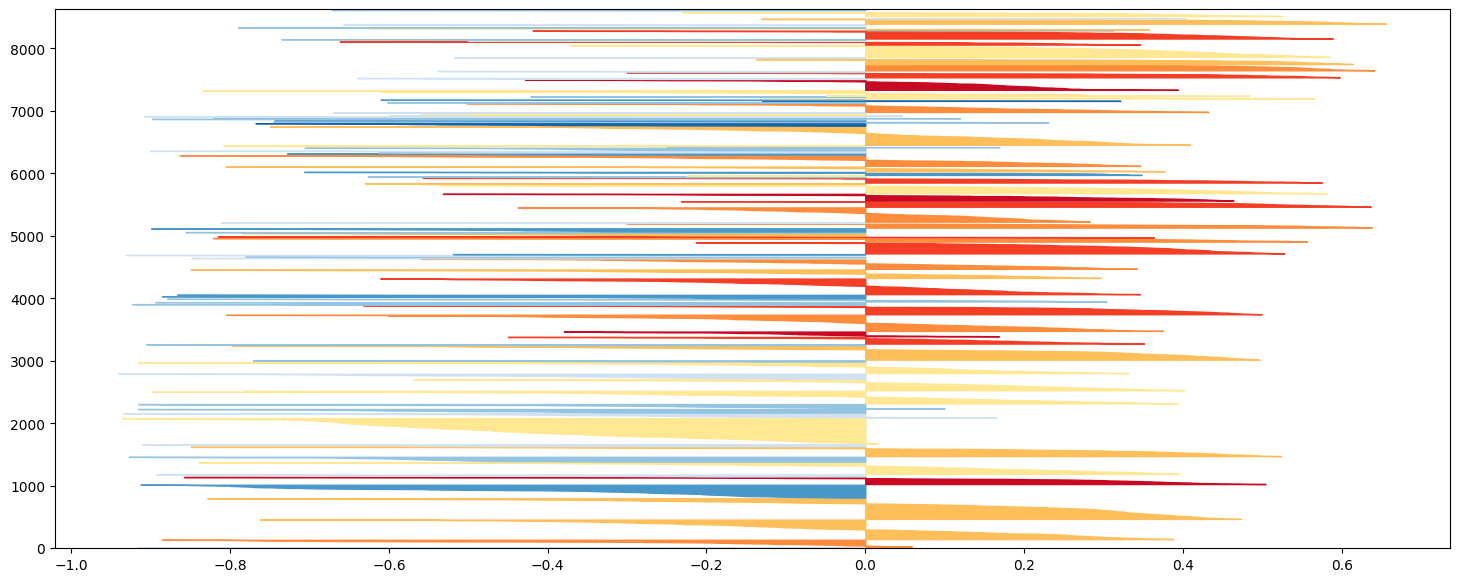

In [36]:
import matplotlib.pyplot as plt
import polars as pl
import matplotlib.pyplot as plt
import numpy as np


n_clusters = len(geocode_cluster_dataframe.df["cluster"].unique())
n_geocodes = len(distance_matrix.squareform())

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 7)
# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
# ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, n_geocodes + (n_clusters + 1) * 10])

y_lower = 10
for i, cluster in enumerate(geocode_cluster_dataframe.df["cluster"].unique()):
    ith_cluster_silhouette_values = (
        geocode_silhouette_score_dataframe
        .df
        .join(geocode_cluster_dataframe.df, on="geocode")
        .filter(pl.col("cluster") == cluster)
        .sort("silhouette_score", descending=True)
    )["silhouette_score"]

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color =  cluster_colors_dataframe.get_color_for_cluster(cluster)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
    )

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples


## Build and plot GeoJSON feature collection

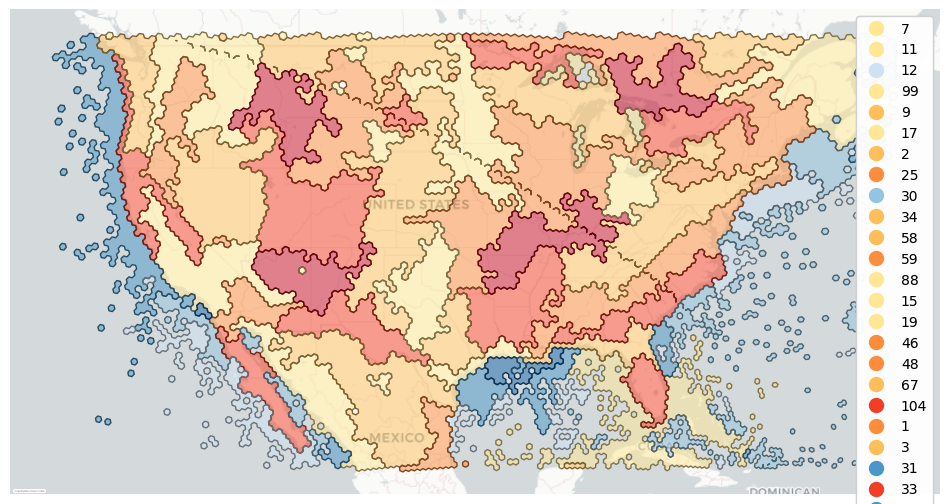

In [37]:
from src.geojson import build_geojson_feature_collection, write_geojson
from src.render import plot_clusters
import matplotlib.pyplot as plt

# Set the figure size
plt.rcParams['figure.figsize'] = [12, 7]

feature_collection = build_geojson_feature_collection(
    cluster_boundary_dataframe,
    cluster_colors_dataframe,
)

write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

## Build and display HTML output

In [38]:
from src.html_output import prepare_full_report_data, render_html, write_html

report_data = prepare_full_report_data(
    cluster_colors_dataframe,
    cluster_significant_differences_dataframe,
    taxonomy_dataframe,
    feature_collection,
)
html_content = render_html('cluster_report.html', report_data)
write_html(html_content, "output.html")


## TSNE 2d plot

In [39]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    metric="precomputed",
    init="random",
    perplexity=min(30, distance_matrix.squareform().shape[0] - 1), # HACK FOR SMALLER DATASETS
)
X_tsne = tsne.fit_transform(distance_matrix.squareform())
tsne.kl_divergence_


0.7748451828956604

In [40]:
import umap

umap = umap.UMAP(
    n_components=2,
    metric="precomputed",
    random_state=42,
    n_neighbors=3000,
    # min_dist=1,
    # init="random",
)
X_umap = umap.fit_transform(distance_matrix.squareform())


/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: >

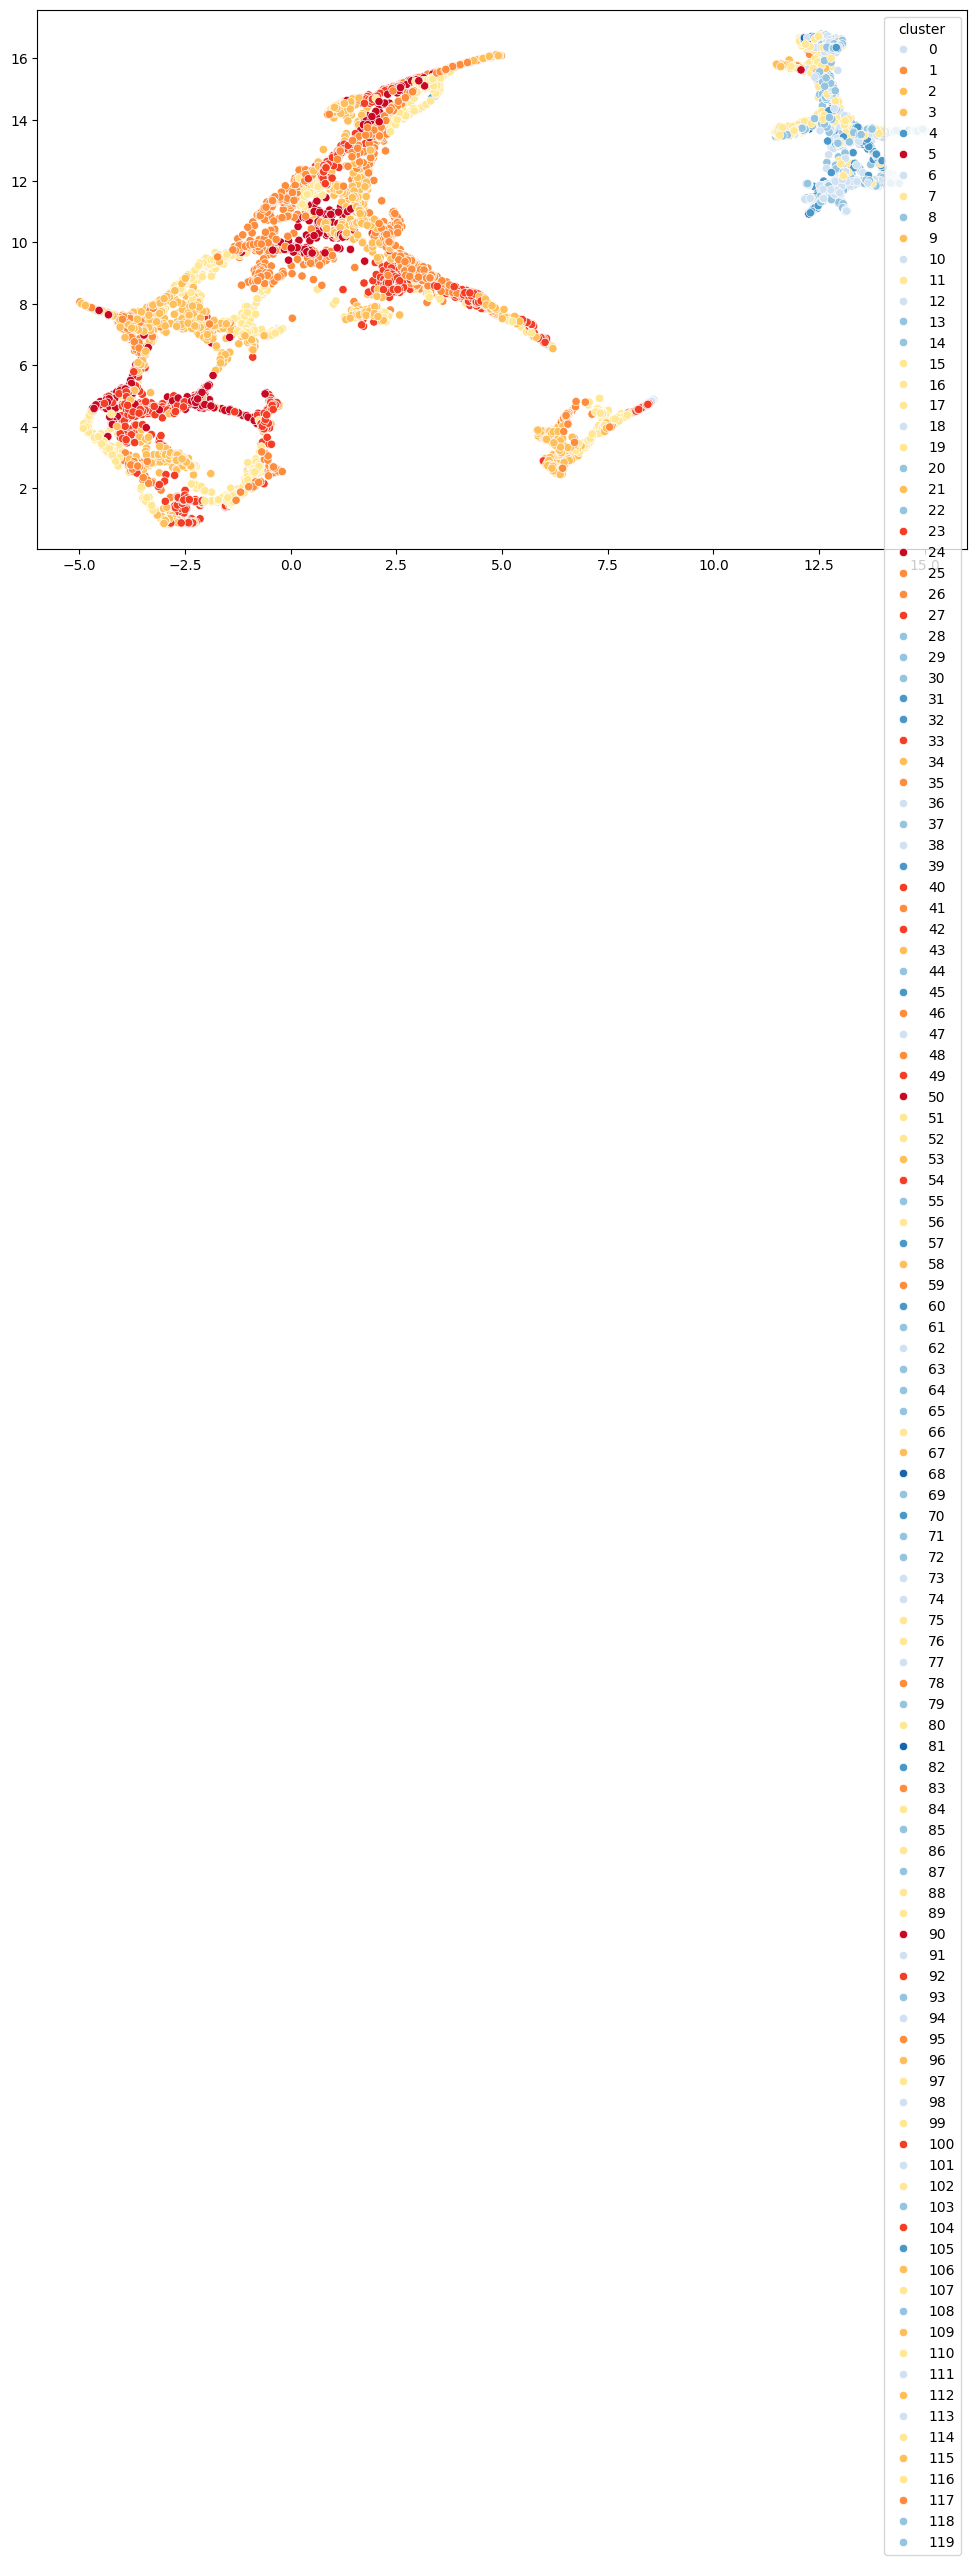

In [41]:
import seaborn as sns

sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=geocode_cluster_dataframe.df["cluster"],
    palette=cluster_colors_dataframe.to_dict(),
    alpha=1,
)

## Clustermap visualization

In [42]:
import seaborn as sns
import polars as pl
from scipy.cluster.hierarchy import linkage


linkage_array = linkage(distance_matrix.condensed(), "ward")

ordered_geocodes = geocode_dataframe.df["geocode"].unique()

def min_max_normalize(series: pl.Series) -> pl.Series:
    return (series - series.min()) / (series.max() - series.min())

col_colors = []
for geocode in ordered_geocodes:
    cluster = geocode_cluster_dataframe.cluster_for_geocode(geocode)
    col_colors.append(cluster_colors_dataframe.get_color_for_cluster(cluster))

data = {}
for species, kingdom, taxonRank in cluster_significant_differences_dataframe.df.select("scientificName", "kingdom", "taxonRank").unique().iter_rows():
    counts = []

    for geocode in ordered_geocodes:
        geocode_counts_species = geocode_taxa_counts_dataframe.df.filter(
            pl.col("geocode") == geocode, pl.col("scientificName") == species
        ).get_column("count").sum()
        geocode_counts_all = geocode_taxa_counts_dataframe.df.filter(
            pl.col("geocode") == geocode
        ).get_column("count").sum()
        geocode_average = geocode_counts_species / geocode_counts_all
        all_average = (
            cluster_taxa_statistics_dataframe.df.filter(
                pl.col("kingdom") == kingdom,
                pl.col("scientificName") == species,
                pl.col("cluster").is_null(),
                pl.col("taxonRank") == taxonRank,
            )
            .get_column("average")
            .item()
        )
        counts.append(geocode_average - all_average)
    counts = pl.Series(
        values=counts,
        name=species,
    )
    # counts = counts / counts.max()
    # counts = counts.pow(1 / 3)
    data[species] = min_max_normalize(counts)


ColumnNotFoundError: scientificName

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'select' <---
DF ["cluster", "taxonId", "percentage_difference"]; PROJECT */3 COLUMNS

In [ ]:
dataframe = pl.DataFrame(data=data)
sns.clustermap(
    data=dataframe,
    col_cluster=False,
    row_cluster=True,
    row_linkage=linkage_array,
    row_colors=col_colors,
    xticklabels=dataframe.columns,
    yticklabels=False,
)